In [ ]:
!pip install transformers datasets accelerate
!pip install sentencepiece 
!pip install nltk

In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

import torch
import torch.nn as nn
from tqdm.auto import tqdm
from accelerate import Accelerator
from accelerate.utils import set_seed
from torch.optim import lr_scheduler, AdamW 
from torch.utils.data import Dataset, DataLoader
from transformers.models.deberta.modeling_deberta import ContextPooler
from transformers import AutoTokenizer, AutoModel, AutoConfig, DataCollatorWithPadding, get_scheduler

In [3]:
def set_all_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    set_seed(seed)

set_all_seed()

Load Data
---------



In [ ]:
os.environ['KAGGLE_USERNAME'] = "xxx"
os.environ['KAGGLE_KEY'] = "xxx"
!kaggle competitions download -c jigsaw-toxic-severity-rating
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!kaggle datasets download -d rajkumarl/ruddit-jigsaw-dataset

!unzip /content/jigsaw-toxic-severity-rating.zip -d jigsaw-toxic-severity-rating/
!unzip /content/jigsaw-toxic-comment-classification-challenge.zip -d jigsaw-toxic-comment-classification-challenge/
!unzip /content/ruddit-jigsaw-dataset.zip -d ruddit-jigsaw-dataset/

In [5]:
hol_data_link = 'https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/data/labeled_data.csv?raw=true'
ethos_data_link = 'https://github.com/intelligence-csd-auth-gr/Ethos-Hate-Speech-Dataset/blob/master/ethos/ethos_data/Ethos_Dataset_Binary.csv?raw=true'

In [6]:
twitter = pd.read_csv(hol_data_link, index_col = 0)
ethos = pd.read_csv(ethos_data_link, sep = ';')
ruddit = pd.read_csv('/content/ruddit-jigsaw-dataset/Dataset/ruddit_with_text.csv')[['txt', 'offensiveness_score']]
toxkaggle = pd.read_csv('/content/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

In [ ]:
val_data = pd.read_csv("/content/jigsaw-toxic-severity-rating/validation_data.csv")
pred_data = pd.read_csv("/content/jigsaw-toxic-severity-rating/comments_to_score.csv")
eval_data = pd.read_csv("/content/jigsaw-toxic-severity-rating/leaderboard.csv")
eval_data = eval_data.loc[(eval_data['left_comment_id'].isin(pred_data.comment_id)) &
                (eval_data['right_comment_id'].isin(pred_data.comment_id))].reset_index(drop=True)

Data preprocessing
---------

Adjust Twitter specific words/symbols

In [8]:
def preprocess_tweets(tweet):
    new_tweet = []
    tokenizer = TweetTokenizer()
    tweet = tokenizer.tokenize(tweet)
    for word in tweet:
        word = '@user' if word.startswith('@') and len(word) > 1 else word
        word = 'http' if word.startswith('http') else word
        new_tweet.append(word)
    return " ".join(new_tweet)

In [9]:
twitter.loc[twitter['class'] == 2, 'class'] = 1
twitter = twitter.rename(columns={"tweet": "text", "class": "label"})
twitter['text'] = twitter['text'].apply(preprocess_tweets) # remove Twitter specific parts 
twitter = twitter[['text', 'label']]

ethos = ethos.rename(columns={"comment": "text", "isHate": "label"})
ethos = ethos.astype({'label': 'int32'})[['label', 'text']]

ruddit = ruddit.loc[ruddit.txt != '[deleted]']
ruddit = ruddit.loc[ruddit.txt != '[removed]']
ruddit = ruddit.rename(columns={'txt':'text', 'offensiveness_score':'label'})
ruddit['label'] = round((ruddit["label"] + 1.) / 2., 0)

toxkaggle['label'] = round(toxkaggle.loc[:,'toxic':].sum(axis=1)/6, 0)
toxkaggle = toxkaggle.rename(columns={'comment_text':'text'})
toxkaggle = toxkaggle[['text', 'label']]

train_data = pd.concat([ruddit, twitter, ethos, toxkaggle]) 

Plot most common words


In [10]:
data = " ".join(train_data['text']).split(' ')
fdist = nltk.FreqDist(data)
most_common_words = pd.DataFrame(fdist.most_common(11), columns=['word', 'count'])
most_common_words = most_common_words.loc[most_common_words.word != '']

[]

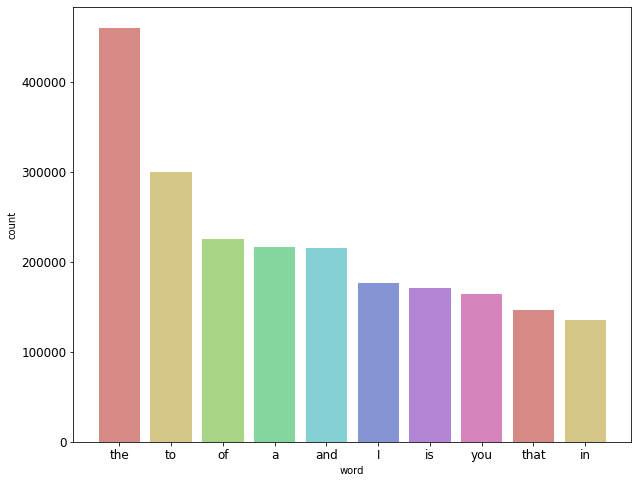

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=most_common_words['word'], y=most_common_words['count'], ax=ax, palette=sns.color_palette("hls", 8), alpha=0.8)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.plot()

Remove stopwords

In [12]:
def remove_stopwords(text, stopwords):
  text = [word for word in text.split(' ') if word.lower() not in stopwords]
  return " ".join(text)

In [13]:
en_stopwords = stopwords.words('english')
train_data['text'] = train_data['text'].apply(remove_stopwords, args=(en_stopwords,))
train_data.head()

,text,label
0,> difference average earnings men women explai...,0.0
1,"myth ""gap"" entirely based sex person.",0.0
3,"assertion women get paid less *same* jobs, get...",0.0
4,said OP that's they're measuring. They're meas...,0.0
5,>Men women payed less job\n\nI think many peop...,0.0


Ratio of non-toxic/toxic comments in final train dataset

In [14]:
train_data['label'].value_counts() 

0.0    163058
1.0     28004
Name: label, dtype: int64

Dataset and Model classes
---------

In [15]:
class ToxicRankDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self._data=data
        self.tokenizer=tokenizer
        self.max_len=max_len
    def __len__(self):
        return len(self._data)
    def __getitem__(self, index):
        tokenized = self.tokenizer(text=self._data['text'].values[index],
                                   padding='max_length',
                                   truncation=True,
                                   max_length=self.max_len,
                                   return_tensors='pt')
        
        if 'label' not in self._data.columns:
          return tokenized['input_ids'].squeeze(), tokenized['attention_mask'].squeeze(), tokenized['token_type_ids'].squeeze()

        target = self._data['label'].values[index]
        return tokenized['input_ids'].squeeze(), tokenized['attention_mask'].squeeze(), tokenized['token_type_ids'].squeeze(), target

In [16]:
class ToxicRankRoBERTa(nn.Module):
    def __init__(self, model_name):
        super(ToxicRankRoBERTa, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(config.hidden_size, 1)
  
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        classification_output = outputs[1]
        logits = self.classifier(classification_output)
        return logits


class ToxicRankDeBERTa(nn.Module):
    def __init__(self, model_name):
        super(ToxicRankDeBERTa, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.pooler = ContextPooler(config)
        output_dim = self.pooler.output_dim
        self.classifier = nn.Linear(output_dim, 1)
  
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        encoder_layer = outputs[0]
        pooled_output = self.pooler(encoder_layer)
        logits = self.classifier(pooled_output)
        return logits

Training and evaluation
---------

In [17]:
def eval(model, dataloader):
  preds = []
  model.eval()
  for step, (batch_input_ids, batch_attention_mask) in enumerate(dataloader):
    with torch.no_grad():
              outputs = model(batch_input_ids, batch_attention_mask).view(-1)
              predictions = outputs.sigmoid()
              preds.append(predictions.cpu().data.numpy())
  return np.concatenate(preds).ravel()

In [18]:
def inference(ranks_data, eval_data):
    scores = []
    ranks = pd.Series(ranks_data['rank'].values, index=ranks_data.comment_id).to_dict()

    for index, row in eval_data.iterrows():
      scores.append(ranks[row['left_comment_id']] < ranks[row['right_comment_id']])
      
    return np.mean(scores)

In [20]:
def train_and_eval(config, train_data, val_data, pred_data, eval_data, roberta=False):

  accelerator = Accelerator(fp16 = True)

  tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
  train = ToxicRankDataset(train_data, tokenizer, config['train_max_len'])
  
  train_dataloader = DataLoader(dataset=train,
                                  shuffle=True,
                                  batch_size=config['train_batch_size'],
                                  num_workers=config['dataloader_num_workers'],
                                  pin_memory=True)

  gradient_accumulation_steps = config['gradient_accumulation_steps']
  num_train_epochs = config['num_train_epochs']

  num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
  max_train_steps = num_train_epochs * num_update_steps_per_epoch

  if roberta:
    model = ToxicRankRoBERTa(config['model_name'])
  else:
    model = ToxicRankDeBERTa(config['model_name'])

  criterion = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
  lr_scheduler = get_scheduler(
        name=config['lr_scheduler_type'],
        optimizer=optimizer,
        num_warmup_steps=config['num_warmup_steps'],
        num_training_steps=max_train_steps,
    )

  # Prepare everything with accelerator.
  train_dataloader, model, optimizer, scheduler = accelerator.prepare(train_dataloader, model, optimizer, lr_scheduler)

  # Recalculate total training steps as the size of the training dataloader may have changed.
  num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
  max_train_steps = num_train_epochs * num_update_steps_per_epoch

  # Training
  completed_steps = 0
  train_loss = []
  progress_bar = tqdm(range(max_train_steps))

  for epoch in range(num_train_epochs):
        model.train()
        for step, (batch_input_ids, batch_attention_mask, batch_token_type_ids, batch_target) in enumerate(train_dataloader):
            with accelerator.autocast():
                logits = model(batch_input_ids, batch_attention_mask, batch_token_type_ids).view(-1)
                loss = criterion(logits, batch_target)

            loss = loss / gradient_accumulation_steps
            accelerator.backward(loss)

            if step % gradient_accumulation_steps == 0 or step == len(train_dataloader) - 1:
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
                progress_bar.update(1)
                completed_steps += 1

            if completed_steps >= max_train_steps:
                break  

            train_loss.append(loss)

  # Validation
  less_toxic = val_data[['less_toxic']].rename(columns={'less_toxic':'text'})
  more_toxic = val_data[['more_toxic']].rename(columns={'more_toxic':'text'})


  less_toxic = ToxicRankDataset(less_toxic, tokenizer, config['val_max_len'])
  less_toxic_dataloader = DataLoader(dataset=less_toxic,
                                shuffle=True,
                                batch_size=config['val_batch_size'],
                                num_workers=config['dataloader_num_workers'],
                                pin_memory=True)
  
  less_toxic_dataloader = accelerator.prepare(less_toxic_dataloader)
  less_toxic_preds = eval(model, less_toxic_dataloader, accelerator)
  less_toxic_preds = less_toxic_preds[:len(less_toxic_dataloader.dataset)]


  more_toxic = ToxicRankDataset(more_toxic, tokenizer, config['val_max_len'])
  more_toxic_dataloader = DataLoader(dataset=more_toxic,
                                  shuffle=True,
                                  batch_size=config['val_batch_size'],
                                  num_workers=config['dataloader_num_workers'],
                                  pin_memory=True)
  
  more_toxic_dataloader = accelerator.prepare(more_toxic_dataloader)
  more_toxic_preds = eval(model, more_toxic_dataloader, accelerator)
  more_toxic_preds = more_toxic_preds[:len(more_toxic_dataloader.dataset)]

  val_score = np.mean(less_toxic_preds < more_toxic_preds)


  # Evaluation
  pred = ToxicRankDataset(pred_data, tokenizer, config['eval_max_len'])
  pred_dataloader = DataLoader(dataset=pred,
                                shuffle=True,
                                batch_size=config['eval_batch_size'],
                                num_workers=config['dataloader_num_workers'],
                                pin_memory=True)
  
  pred_dataloader = accelerator.prepare(pred_dataloader)
  preds = eval(model, pred_dataloader, accelerator)
  preds = preds[:len(pred_dataloader.dataset)]

  ranks = preds.argsort()
  ranks_data = pd.DataFrame(data={'comment_id': pred_data['comment_id'], 'rank': ranks})
  eval_score = inference(ranks_data, eval_data)

  return train_loss, val_score, eval_score, ranks_data

In [ ]:
CONFIG = {"model_name" : 'roberta-base',

          "train_max_len": 192,
          "val_max_len": 192,
          "eval_max_len": 256,

          "train_batch_size": 64,
          "val_batch_size": 32,
          "eval_batch_size": 16,

          "dataloader_num_workers": 4,

          "learning_rate": 5e-5,
          "num_train_epochs": 4,
          "gradient_accumulation_steps": 6,
          "lr_scheduler_type": "linear", 
          "num_warmup_steps": 2,

}

roberta_base_train_loss, roberta_base_val_score, roberta_base_eval_score, roberta_ranks_data = train_and_eval(CONFIG, train_data, 
                                                                                          val_data, pred_data, eval_data, roberta=True)

In [ ]:
CONFIG = {"model_name" : 'cardiffnlp/twitter-roberta-base-hate',

          "train_max_len": 200,
          "val_max_len": 192,
          "eval_max_len": 256,

          "train_batch_size": 16,
          "val_batch_size": 8,
          "eval_batch_size": 8,

          "dataloader_num_workers": 4,

          "learning_rate": 1e-5,
          "num_train_epochs": 3,
          "gradient_accumulation_steps": 4,
          "lr_scheduler_type": "linear", 
          "num_warmup_steps": 2,

}

roberta_hate_train_loss, roberta_hate_val_score, roberta_hate_eval_score = train_and_eval(CONFIG, train_data, 
                                                                                          val_data, pred_data, eval_data, roberta=True)

In [ ]:
CONFIG = {"model_name" : 'microsoft/deberta-base',

          "train_max_len": 150,
          "val_max_len": 200,
          "eval_max_len": 200,

          "train_batch_size": 16,
          "val_batch_size": 16,
          "eval_batch_size": 16,

          "dataloader_num_workers": 4,

          "learning_rate": 3e-5,
          "num_train_epochs": 3,
          "gradient_accumulation_steps": 8,
          "lr_scheduler_type": "linear", 
          "num_warmup_steps": 2,

}

deberta_base_train_loss, deberta_base_val_score, deberta_base_eval_score, deberta_ranks_data = train_and_eval(CONFIG, train_data, 
                                                                                          val_data, pred_data, eval_data, roberta=False)

In [ ]:
CONFIG = {"model_name" : 'Narrativaai/deberta-v3-small-finetuned-hate_speech18',

          "train_max_len": 256,
          "val_max_len": 256,
          "eval_max_len": 256,

          "train_batch_size": 32,
          "val_batch_size": 16,
          "eval_batch_size": 16,

          "dataloader_num_workers": 4,

          "learning_rate": 2e-5,
          "num_train_epochs": 5,
          "gradient_accumulation_steps": 2,
          "lr_scheduler_type": "linear", 
          "num_warmup_steps": 2,

}

deberta_small_train_loss, deberta_small_val_score, deberta_small_eval_score, deberta_small_ranks_data = train_and_eval(CONFIG, train_data, 
                                                                                          val_data, pred_data, eval_data, roberta=False)